<a href="https://colab.research.google.com/github/anushree825/my_unet_proj/blob/main/unet_proj_pycode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/qubvel/segmentation_models.pytorch > /dev/null 2>&1 # Install segmentations_models.pytorch, with no bash output.

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!unzip -q /content/drive/MyDrive/cv/Siim.zip -d /content/drive/MyDrive/cv/data


#losses.py

In [5]:
##losses.py
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn
from torch.autograd import Variable

try:
    from itertools import ifilterfalse
except ImportError:  # py3k
    from itertools import filterfalse

eps = 1e-6


def dice_round(preds, trues):
    preds = preds.float()
    return soft_dice_loss(preds, trues)


def soft_dice_loss(outputs, targets, per_image=False):
    batch_size = outputs.size()[0]
    eps = 1e-5
    if not per_image:
        batch_size = 1
    dice_target = targets.contiguous().view(batch_size, -1).float()
    dice_output = outputs.contiguous().view(batch_size, -1)
    intersection = torch.sum(dice_output * dice_target, dim=1)
    union = torch.sum(dice_output, dim=1) + torch.sum(dice_target, dim=1) + eps
    loss = (1 - (2 * intersection + eps) / union).mean()

    return loss


def jaccard(outputs, targets, per_image=False, non_empty=False, min_pixels=5):
    batch_size = outputs.size()[0]
    eps = 1e-3
    if not per_image:
        batch_size = 1
    dice_target = targets.contiguous().view(batch_size, -1).float()
    dice_output = outputs.contiguous().view(batch_size, -1)
    target_sum = torch.sum(dice_target, dim=1)
    intersection = torch.sum(dice_output * dice_target, dim=1)
    losses = 1 - (intersection + eps) / (torch.sum(dice_output + dice_target, dim=1) - intersection + eps)
    if non_empty:
        assert per_image == True
        non_empty_images = 0
        sum_loss = 0
        for i in range(batch_size):
            if target_sum[i] > min_pixels:
                sum_loss += losses[i]
                non_empty_images += 1
        if non_empty_images == 0:
            return 0
        else:
            return sum_loss / non_empty_images

    return losses.mean()


class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True, per_image=False):
        super().__init__()
        self.size_average = size_average
        self.register_buffer('weight', weight)
        self.per_image = per_image

    def forward(self, input, target):
        return soft_dice_loss(input, target, per_image=self.per_image)


class JaccardLoss(nn.Module):
    def __init__(self, weight=None, size_average=True, per_image=False, non_empty=False, apply_sigmoid=False,
                 min_pixels=5):
        super().__init__()
        self.size_average = size_average
        self.register_buffer('weight', weight)
        self.per_image = per_image
        self.non_empty = non_empty
        self.apply_sigmoid = apply_sigmoid
        self.min_pixels = min_pixels

    def forward(self, input, target):
        if self.apply_sigmoid:
            input = torch.sigmoid(input)
        return jaccard(input, target, per_image=self.per_image, non_empty=self.non_empty, min_pixels=self.min_pixels)


class StableBCELoss(nn.Module):
    def __init__(self):
        super(StableBCELoss, self).__init__()

    def forward(self, input, target):
        input = input.float().view(-1)
        target = target.float().view(-1)
        neg_abs = - input.abs()
        # todo check correctness
        loss = input.clamp(min=0) - input * target + (1 + neg_abs.exp()).log()
        return loss.mean()


class ComboLoss(nn.Module):
    def __init__(self, weights, per_image=False, channel_weights=[1, 0.5, 0.5], channel_losses=None):
        super().__init__()
        self.weights = weights
        self.bce = StableBCELoss()
        self.dice = DiceLoss(per_image=False)
        self.jaccard = JaccardLoss(per_image=False)
        self.lovasz = LovaszLoss(per_image=per_image)
        self.lovasz_sigmoid = LovaszLossSigmoid(per_image=per_image)
        self.focal = FocalLoss2d()
        self.mapping = {'bce': self.bce,
                        'dice': self.dice,
                        'focal': self.focal,
                        'jaccard': self.jaccard,
                        'lovasz': self.lovasz,
                        'lovasz_sigmoid': self.lovasz_sigmoid}
        self.expect_sigmoid = {'dice', 'focal', 'jaccard', 'lovasz_sigmoid'}
        self.per_channel = {'dice', 'jaccard', 'lovasz_sigmoid'}
        self.values = {}
        self.channel_weights = channel_weights
        self.channel_losses = channel_losses

    def forward(self, outputs, targets):
        loss = 0
        weights = self.weights
        sigmoid_input = torch.sigmoid(outputs)
        for k, v in weights.items():
            if not v:
                continue
            val = 0
            if k in self.per_channel:
                channels = targets.size(1)
                for c in range(channels):
                    if not self.channel_losses or k in self.channel_losses[c]:
                        val += self.channel_weights[c] * self.mapping[k](sigmoid_input[:, c, ...] if k in self.expect_sigmoid else outputs[:, c, ...],
                                               targets[:, c, ...])

            else:
                val = self.mapping[k](sigmoid_input if k in self.expect_sigmoid else outputs, targets)

            self.values[k] = val
            loss += self.weights[k] * val
        return loss.clamp(min=1e-5)


def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Alg. 1 in paper
    """
    p = len(gt_sorted)
    gts = gt_sorted.sum()
    intersection = gts.float() - gt_sorted.float().cumsum(0)
    union = gts.float() + (1 - gt_sorted).float().cumsum(0)
    jaccard = 1. - intersection / union
    if p > 1:  # cover 1-pixel case
        jaccard[1:p] = jaccard[1:p] - jaccard[0:-1]
    return jaccard


def lovasz_hinge(logits, labels, per_image=True, ignore=None):
    """
    Binary Lovasz hinge loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      per_image: compute the loss per image instead of per batch
      ignore: void class id
    """
    if per_image:
        loss = mean(lovasz_hinge_flat(*flatten_binary_scores(log.unsqueeze(0), lab.unsqueeze(0), ignore))
                    for log, lab in zip(logits, labels))
    else:
        loss = lovasz_hinge_flat(*flatten_binary_scores(logits, labels, ignore))
    return loss


def lovasz_hinge_flat(logits, labels):
    """
    Binary Lovasz hinge loss
      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
      labels: [P] Tensor, binary ground truth labels (0 or 1)
      ignore: label to ignore
    """
    if len(labels) == 0:
        # only void pixels, the gradients should be 0
        return logits.sum() * 0.
    signs = 2. * labels.float() - 1.
    errors = (1. - logits * Variable(signs))
    errors_sorted, perm = torch.sort(errors, dim=0, descending=True)
    perm = perm.data
    gt_sorted = labels[perm]
    grad = lovasz_grad(gt_sorted)
    loss = torch.dot(F.relu(errors_sorted), Variable(grad))
    return loss


def flatten_binary_scores(scores, labels, ignore=None):
    """
    Flattens predictions in the batch (binary case)
    Remove labels equal to 'ignore'
    """
    scores = scores.view(-1)
    labels = labels.view(-1)
    if ignore is None:
        return scores, labels
    valid = (labels != ignore)
    vscores = scores[valid]
    vlabels = labels[valid]
    return vscores, vlabels


def lovasz_sigmoid(probas, labels, per_image=False, ignore=None):
    """
    Multi-class Lovasz-Softmax loss
      probas: [B, C, H, W] Variable, class probabilities at each prediction (between 0 and 1)
      labels: [B, H, W] Tensor, ground truth labels (between 0 and C - 1)
      only_present: average only on classes present in ground truth
      per_image: compute the loss per image instead of per batch
      ignore: void class labels
    """
    if per_image:
        loss = mean(lovasz_sigmoid_flat(*flatten_binary_scores(prob.unsqueeze(0), lab.unsqueeze(0), ignore))
                          for prob, lab in zip(probas, labels))
    else:
        loss = lovasz_sigmoid_flat(*flatten_binary_scores(probas, labels, ignore))
    return loss


def lovasz_sigmoid_flat(probas, labels):
    """
    Multi-class Lovasz-Softmax loss
      probas: [P, C] Variable, class probabilities at each prediction (between 0 and 1)
      labels: [P] Tensor, ground truth labels (between 0 and C - 1)
      only_present: average only on classes present in ground truth
    """
    fg = labels.float()
    errors = (Variable(fg) - probas).abs()
    errors_sorted, perm = torch.sort(errors, 0, descending=True)
    perm = perm.data
    fg_sorted = fg[perm]
    loss = torch.dot(errors_sorted, Variable(lovasz_grad(fg_sorted)))
    return loss

def symmetric_lovasz(outputs, targets, ):
    return (lovasz_hinge(outputs, targets) + lovasz_hinge(-outputs, 1 - targets)) / 2

def mean(l, ignore_nan=False, empty=0):
    """
    nanmean compatible with generators.
    """
    l = iter(l)
    if ignore_nan:
        l = ifilterfalse(np.isnan, l)
    try:
        n = 1
        acc = next(l)
    except StopIteration:
        if empty == 'raise':
            raise ValueError('Empty mean')
        return empty
    for n, v in enumerate(l, 2):
        acc += v
    if n == 1:
        return acc
    return acc / n


class LovaszLoss(nn.Module):
    def __init__(self, ignore_index=255, per_image=True):
        super().__init__()
        self.ignore_index = ignore_index
        self.per_image = per_image

    def forward(self, outputs, targets):
        outputs = outputs.contiguous()
        targets = targets.contiguous()
        return symmetric_lovasz(outputs, targets)

class LovaszLossSigmoid(nn.Module):
    def __init__(self, ignore_index=255, per_image=True):
        super().__init__()
        self.ignore_index = ignore_index
        self.per_image = per_image

    def forward(self, outputs, targets):
        outputs = outputs.contiguous()
        targets = targets.contiguous()
        return lovasz_sigmoid(outputs, targets, per_image=self.per_image, ignore=self.ignore_index)


class FocalLoss2d(nn.Module):
    def __init__(self, gamma=2, ignore_index=255):
        super().__init__()
        self.gamma = gamma
        self.ignore_index = ignore_index

    def forward(self, outputs, targets):
        outputs = outputs.contiguous()
        targets = targets.contiguous()
        eps = 1e-8
        non_ignored = targets.view(-1) != self.ignore_index
        targets = targets.view(-1)[non_ignored].float()
        outputs = outputs.contiguous().view(-1)[non_ignored]
        outputs = torch.clamp(outputs, eps, 1. - eps)
        targets = torch.clamp(targets, eps, 1. - eps)
        pt = (1 - targets) * (1 - outputs) + targets * outputs
        return (-(1. - pt) ** self.gamma * torch.log(pt)).mean()


#lung dataloader

In [53]:
# -*- coding: utf-8 -*-
"""
Created on Sat Mar 21 18:49:40 2020

"""

import os
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import torch
import torchvision.transforms as trans
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt 

import albumentations as A
from albumentations.pytorch import ToTensor


class lungData(Dataset):
    
    def __init__(self,args,im_list,masks_list, labels = [],transform = None,im_type = 'RGB'):
        self.im_list = im_list
        # print("init --- len(self.im_list):",len(self.im_list))
        self.masks_list = masks_list
        self.labels = np.array(labels)
        
        self.num_classes = args.num_classes
        self.one_hot = args.one_hot
        self.transform_img = transform
        self.transform_mask = A.Compose([
        A.Resize(args.im_dim[0],args.im_dim[1]),
        # A.Normalize(mean=(0.456), std=(0.225)),
        ToTensor(),
        ])
        
        assert im_type in ['RGB','L']
        self.im_type = im_type
        
    def __len__(self):
        return len(self.im_list)
    
    def __getitem__(self,idx):
        # print("getitem -- im_list.shape",len(self.im_list), "idx:", idx)
        im = Image.open(self.im_list[idx]).convert(self.im_type)
        mask = Image.open(self.masks_list[idx])
        # print('getitem -- im,mask:', np.array(im).shape, np.array(mask).shape, "idx:", idx)
        # print('getitem -- self.transform:',bool(self.transform))
        if(self.transform_img):
            # print("getitem -- in self.transform loop: ")
            im = self.transform_img(image=np.array(im))['image']
        if(self.transform_mask):
            mask = self.transform_mask(image =np.array(mask))['image']
            # print('getitem -- im.shape', im)

        # print("getitem -- transform complet succesfully, idx:" ,idx)
        if(self.labels.any()):
            label= np.array([self.labels[idx]])
            label = torch.from_numpy(label)
            if(self.one_hot):
                label = F.one_hot(label,num_classes = self.num_classes)
            # im.show(im)
            # print("getitem -- im,mask,label",im,mask,label)
            return im,mask,label
        else:
            return im,mask
    
def create_dataloaders(args):
    
    transforms = A.Compose([
        A.Resize(args.im_dim[0],args.im_dim[1]),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensor(),
        ])
    # print('args.im_dim:',args.im_dim)
    
    data = pd.read_csv(args.train_csv)[:10]
    
    train, val = train_test_split(data, test_size = args.val_split)
    
    # print('train.shape, val_shape:', train.shape, val.shape)

    im_train = [args.im_dir + im for im in train['im_path']]
    mask_train = [args.mask_dir + im for im in train['im_path']]

    im_val = [args.im_dir + im for im in val['im_path']]
    mask_val = [args.mask_dir + im for im in val['im_path']]

    im_save = [args.im_dir + im for im in data['im_path']]
    mask_save = [args.mask_dir + im for im in data['im_path']]

    # print('im_train.shape, mask_train.shape:', len(im_train), len(mask_train))
    # print("im_train", im_train[0])
    # im = Image.open(im_train[0])
    # plt.show(im)
    # img = transforms(im)
    # plt.show(img)
    # exit()

    train_labels = train['label']
    val_labels = val['label']

    # print("train['label'].shape:", len(train['label']))
    
    train_data = lungData(args, im_train, mask_train, labels = train_labels, transform = transforms, im_type='RGB')
    val_data = lungData(args, im_val, mask_val, labels = val_labels, transform = transforms, im_type='RGB')
    save_data = lungData(args, im_save, mask_save, transform = transforms, im_type='RGB') 
    # print("len(train_data.im_list):",len(train_data.im_list))

    train_loader = DataLoader(train_data, batch_size = args.batch_sz, shuffle = True, num_workers = args.num_workers, drop_last = args.drop_last)
    # print("train_loader:",len(train_loader))
    val_loader = DataLoader(val_data, batch_size = args.batch_sz, shuffle = False, num_workers = args.num_workers, drop_last = args.drop_last)
    save_loader = DataLoader(save_data, batch_size = args.batch_sz, shuffle = False, num_workers = args.num_workers)

    return {'train':train_loader, 'val':val_loader, 'save':save_loader}

        


#lovasses_losses

In [4]:
#lovasses_losses.py
from __future__ import print_function, division

import torch
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
try:
    from itertools import  ifilterfalse
except ImportError: # py3k
    from itertools import  filterfalse as ifilterfalse

def iou_binary(preds, labels, EMPTY=1., ignore=None, per_image=True):
    """
    IoU for foreground class
    binary: 1 foreground, 0 background
    """
    if not per_image:
        preds, labels = (preds,), (labels,)
    ious = []
    for pred, label in zip(preds, labels):
        intersection = ((label == 1) & (pred == 1)).sum()
        union = ((label == 1) | ((pred == 1) & (label != ignore))).sum()
        if not union:
            iou = EMPTY
        else:
            iou = float(intersection) / float(union)
        ious.append(iou)
    iou = mean(ious)    # mean accross images if per_image
    return 100 * iou

#eval_epoch and train.py

In [28]:
# -*- coding: utf-8 -*-
"""
Created on Sat Mar 21 19:40:51 2020

"""

import os

import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
# import lovasz_losses as L
# from losses import ComboLoss
import time



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')




    

def eval_epoch(args, loader, model, criterion, epoch):
    
    losses = []
    iou = []
    with torch.no_grad():
        tepoch = tqdm(range(len(loader)),unit='batch')

    # with tqdm(total=len(loader), unit='batch') as tepoch:
        # print("len(loader):" ,len(loader))
        for idx,(im,mask,label) in zip(tepoch,loader):

            tepoch.set_description(f"Epoch (Val) {epoch}")
            
            im = im.to(device)
            mask = mask.to(device)
            mask = torch.unsqueeze(mask,1)
            # print("train -- mask:", mask.shape)

            # label = label.to(device).squeeze()
            
            out = model(im)
            # print("train -- out:", out.shape)
            loss = criterion(out,mask)
            
            losses.append(loss.item())

            out = torch.sigmoid(out)
            preds = (out.data > args.threshold).long()
            iou.append(iou_binary(preds, mask, per_image=True))

            tepoch.set_postfix(batch_loss=loss.item(), batch_iou = iou[-1],idx = idx)
            
            if(args.debug and idx == 10):break
    
    print('Epoch (Val) {0} Mean Loss [{1:.8f}], mIOU [{2:.8f}]'.format(epoch, np.mean(losses), np.mean(iou)))
        


def train(args, loaders, model):
    
    to_optim = [{'params':model.parameters(),'lr':args.lr,'weight_decay':args.decay}]
    optimizer = optim.Adam(to_optim)

    # tau = list(map(int,args.tau.split(',')))
    # scheduler    = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=tau, gamma=args.gamma)

    criterion = ComboLoss(**{'weights':{'bce':3, 'dice':1, 'focal':4}})
    # model = model.to(device)
    for epoch in range(args.num_epochs):
        
        model.train()
        print('begin train')
        train_epoch(args, loaders['train'], model, optimizer, criterion, epoch)
        
        model.eval()
        eval_epoch(args, loaders['val'], model, criterion, epoch)
        
        # scheduler.step()
        
    if(args.save_model):
        torch.save(model.state_dict(), args.model_dict_path)


# def train(args, loaders, model):

#     ENCODER = 'se_resnext50_32x4d'
#     ENCODER_WEIGHTS = 'imagenet'
#     CLASSES = ['0','1']
#     ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multicalss segmentation
#     DEVICE = device

#     # create segmentation model with pretrained encoder
#     model = smp.FPN(
#         encoder_name=ENCODER, 
#         encoder_weights=ENCODER_WEIGHTS, 
#         classes=len(CLASSES), 
#         activation=ACTIVATION,
#     )



#     loss = smp.utils.losses.DiceLoss()
#     metrics = [
#         smp.utils.metrics.IoU(threshold=0.5),
#     ]

#     optimizer = torch.optim.Adam([ 
#         dict(params=model.parameters(), lr=args.lr),
#     ])

#     train_epoch = smp.utils.train.TrainEpoch(
#         model, 
#         loss=loss, 
#         metrics=metrics, 
#         optimizer=optimizer,
#         device=DEVICE,
#         verbose=True,
#     )

#     valid_epoch = smp.utils.train.ValidEpoch(
#         model, 
#         loss=loss, 
#         metrics=metrics, 
#         device=DEVICE,
#         verbose=True,
#     )


#     max_score = 0

#     for i in range(0, args.num_epochs):
        
#         print('\nEpoch: {}'.format(i))
#         train_logs = train_epoch.run(loaders['train'])
#         valid_logs = valid_epoch.run(loaders['val'])
        
#         # do something (save model, change lr, etc.)
#         if max_score < valid_logs['iou_score']:
#             max_score = valid_logs['iou_score']
#             # torch.save(model, './best_model.pth')
#             if(args.save_model):
#                 torch.save(model.state_dict(), args.model_dict_path)
#             print('Model saved!')
            
#         if i == 25:
#             optimizer.param_groups[0]['lr'] = args.lr
#             print('Decrease decoder learning rate to 1e-5!')
        
#     # to_optim = [{'params':model.parameters(),'lr':args.lr,'weight_decay':args.decay}]
#     # optimizer = optim.Adam(to_optim)

#     # tau = list(map(int,args.tau.split(',')))
#     # scheduler    = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=tau, gamma=args.gamma)

#     # criterion = ComboLoss(**{'weights':{'bce':3, 'dice':1, 'focal':4}})
    
#     # for epoch in range(args.num_epochs):
        
#     #     model.train()
#     #     print('begin train')
#     #     train_epoch(args, loaders['train'], model, optimizer, criterion, epoch)
        
#     #     model.eval()
#     #     eval_epoch(args, loaders['val'], model, criterion, epoch)
        
#     #     # scheduler.step()
        
#     # if(args.save_model):
#     #     torch.save(model.state_dict(), args.model_dict_path)
        




#save_output.py

In [43]:
# -*- coding: utf-8 -*-
"""
Created on Wed Aug 26 07:44:17 2020
"""

import os

import torch
import numpy as np
import warnings
from tqdm import tqdm
warnings.filterwarnings("ignore")

from skimage.io import imsave

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def save_output(args, model, loader):
    
    if(not os.path.exists('/content/drive/MyDrive/cv/models/results')): 
        os.mkdir('/content/drive/MyDrive/cv/models/results')
    
    count = 0

    with torch.no_grad():
        for idx,(im,mask) in enumerate(tqdm(loader)):
            
            im = im.to(device)
            torch.cuda.empty_cache()

            out = model(im)
            # softmax = torch.nn.functional.log_softmax(out, dim=1)
            # out = torch.argmax(softmax, dim=1)

            out = (out.squeeze().data > args.threshold).long()

            # print(out.shape)
            for j in range(out.size(0)):
                    
                    out_im =  out[j].detach().cpu().numpy()
                    out_im *= 255
                    plt.figure(figsize = [5,5])
                    plt.imshow(out_im.astype(np.uint8),cmap='gray')
                    # plt.imshow(img3)
                    plt.axis('off')
                    plt.show()
                    
                    imsave('/content/drive/MyDrive/cv/results/' + str(count) + '.jpg', out_im.astype(np.uint8), cmap = 'gray') # Create a results/ directory before running
                    
                    count+=1
            del im,out




#main.py

In [60]:
# -*- coding: utf-8 -*-
"""
Created on Tue Aug 25 13:41:07 2020

"""
import os
import argparse

import torch, torch.nn as nn

# from unet import ResnetSuperVision
# from lung_dataloader import create_dataloaders
# from train import train
# from save_output import save_output

import segmentation_models_pytorch as smp

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device",device)
# device = 'cpu'

class arg:
  def __init__(self):
    self.im_dim = (224,224)  # size of input image
    self.im_dir = '/content/drive/MyDrive/cv/data/jpg-images-train/images/' #help = 'Path to images directory'
    self.mask_dir = '/content/drive/MyDrive/cv/data/jpg-images-train/masks/' # help = 'Path to segmentation masks directory'
    self.train_csv = '/content/drive/MyDrive/cv/siim_train.csv' # help = 'Path to train csv'
    self.one_hot = False #help = 'use one hot labels ?'
    self.batch_sz = 4 #help = 'batch size for dataset'
    self.num_workers = 4 #help = 'Number of workers for dataloader'
    self.drop_last = True #help = 'Drop last batch of size different from batch_sz'
    self.val_split = 0.2  #help = 'Fraction of data used for validation'
    self.num_classes = 2 #help = 'Number of classes in data'
    self.out_channels = 1 #help = 'Number of channels of output image'
    self.bilinear = True #help = 'Should UNet expansion use bilinear interpolation or conv.T'
    self.lr = 1e-4 #help = 'learning rate'
    self.decay = 0.0004 #help = 'decay rate for adam'
    self.tau = '30,35' #help = 'milstones for multistepLR'
    self.gamma = 0.3 #help = 'gamma for multistepLR'
    self.num_epochs = 3 #help = 'number of epochs'
    self.threshold = 0.5 #help = 'threshold for segmentation'
    self.save_model = True #help = 'save model?'
    self.model_dict_path = '/content/drive/MyDrive/cv/models/model_default_1.pth' #help = 'file in which model parameters are saved'
    self.load_model = False #help = 'load model parameters?'
    self.save_results = False #help = 'save output images'
    self.debug = False #help = 'If debug then code will run will less batches for debug purposes'

args = arg()


loaders = create_dataloaders(args)
print("Creation of dataloader complete")

# im = (next(iter(loaders['train'])))
# print("chk im.shape:",im.shape)
# print(len(loaders['train']))
# for i, data in enumerate(loaders['train']):
#     x_imgs, masks, _ = data
#     print(x_imgs.shape)
#     print(masks.shape)
# exit()

# model = ResnetSuperVision(args.out_channels, backbone_arch='resnet34')

# aux_params=dict(
#     pooling='avg',             # one of 'avg', 'max'
#     # dropout=0.5,               # dropout ratio, default is None
#     activation='sigmoid',      # activation function, default is None
#     classes=2,                 # define number of output labels
# )

# model = smp.Unet("resnet34", encoder_weights="imagenet", aux_params=aux_params, in_channels=3 )
model = smp.Unet("resnet34", encoder_weights="imagenet", in_channels=3, classes=1)
# print(model)

device cuda
Creation of dataloader complete


#train_epoch

In [51]:
def train_epoch(args, loader, model, optimizer, criterion, epoch):
    print("enter train")
    
    losses = []
    iou = []
    
    # for idx in enumerate(len(loader)):
    tepoch = tqdm(range(len(loader)),unit='batch')

    # with tqdm(total=len(loader), unit='batch') as tepoch:
    print("len(loader):" ,len(loader))
    for idx,(im,mask,label) in zip(tepoch,loader):
        # print('yay')
        tepoch.set_description(f"Epoch (Train) {epoch}")

        im = im.to(device)
        mask = mask.to(device)
        mask = torch.unsqueeze(mask,1)
        # print("train -- mask:", mask.shape)

        # label = label.to(device).squeeze()
        
        out = model(im)
        # print("train -- out:", out.shape)
        loss = criterion(out,mask)
        loss.backward()
        
        optimizer.zero_grad()
        
        optimizer.step()
        
        losses.append(loss.item())

        with torch.no_grad():
            temp_out = torch.sigmoid(out)
            preds = (temp_out.data > args.threshold).long()
            iou.append(iou_binary(preds, mask, per_image=True))
        
        tepoch.set_postfix(batch_loss=loss.item(), batch_iou = iou[-1], idx = idx)

        if(args.debug and idx == 5):break
    print('Epoch (Train) {0} Mean Loss [{1:.8f}], mIOU [{2:.8f}]'.format(epoch, np.mean(losses), np.mean(iou)))

#training - main.py














  0%|          | 0/2 [00:00<?, ?batch/s]

begin train
enter train
len(loader): 2















Epoch (Train) 0:   0%|          | 0/2 [00:00<?, ?batch/s]












Epoch (Train) 0:   0%|          | 0/2 [00:00<?, ?batch/s, batch_iou=0.0848, batch_loss=11.4, idx=0]












Epoch (Train) 0:  50%|█████     | 1/2 [00:00<00:00,  1.80batch/s, batch_iou=0.0848, batch_loss=11.4, idx=0]












Epoch (Train) 0:  50%|█████     | 1/2 [00:00<00:00,  1.80batch/s, batch_iou=0.0848, batch_loss=11.4, idx=0]












Epoch (Train) 0:  50%|█████     | 1/2 [00:00<00:00,  1.80batch/s, batch_iou=1.61, batch_loss=11.3, idx=1]  












Epoch (Train) 0: 100%|██████████| 2/2 [00:00<00:00,  2.45batch/s, batch_iou=1.61, batch_loss=11.3, idx=1]













0batch [00:00, ?batch/s]

Epoch (Train) 0 Mean Loss [11.33662367], mIOU [0.84984045]


0batch [00:00, ?batch/s]













  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch (Val) 0 Mean Loss [nan], mIOU [nan]
begin train
enter train
len(loader): 2















Epoch (Train) 1:   0%|          | 0/2 [00:00<?, ?batch/s]












Epoch (Train) 1:   0%|          | 0/2 [00:00<?, ?batch/s, batch_iou=0.696, batch_loss=11.3, idx=0]












Epoch (Train) 1:  50%|█████     | 1/2 [00:00<00:00,  1.87batch/s, batch_iou=0.696, batch_loss=11.3, idx=0]












Epoch (Train) 1:  50%|█████     | 1/2 [00:00<00:00,  1.87batch/s, batch_iou=0.696, batch_loss=11.3, idx=0]












Epoch (Train) 1:  50%|█████     | 1/2 [00:00<00:00,  1.87batch/s, batch_iou=0.925, batch_loss=11.3, idx=1]












Epoch (Train) 1: 100%|██████████| 2/2 [00:00<00:00,  2.64batch/s, batch_iou=0.925, batch_loss=11.3, idx=1]













0batch [00:00, ?batch/s]

Epoch (Train) 1 Mean Loss [11.29341173], mIOU [0.81028619]


0batch [00:00, ?batch/s]













  0%|          | 0/2 [00:00<?, ?batch/s]

Epoch (Val) 1 Mean Loss [nan], mIOU [nan]
begin train
enter train
len(loader): 2















Epoch (Train) 2:   0%|          | 0/2 [00:00<?, ?batch/s]












Epoch (Train) 2:   0%|          | 0/2 [00:00<?, ?batch/s, batch_iou=1.07, batch_loss=11.2, idx=0]












Epoch (Train) 2:  50%|█████     | 1/2 [00:00<00:00,  1.92batch/s, batch_iou=1.07, batch_loss=11.2, idx=0]












Epoch (Train) 2:  50%|█████     | 1/2 [00:00<00:00,  1.92batch/s, batch_iou=1.07, batch_loss=11.2, idx=0]












Epoch (Train) 2:  50%|█████     | 1/2 [00:00<00:00,  1.92batch/s, batch_iou=0.611, batch_loss=11.4, idx=1]












Epoch (Train) 2: 100%|██████████| 2/2 [00:00<00:00,  2.64batch/s, batch_iou=0.611, batch_loss=11.4, idx=1]













0batch [00:00, ?batch/s]

Epoch (Train) 2 Mean Loss [11.27793169], mIOU [0.83847505]


0batch [00:00, ?batch/s]


Epoch (Val) 2 Mean Loss [nan], mIOU [nan]















  0%|          | 0/3 [00:00<?, ?it/s]

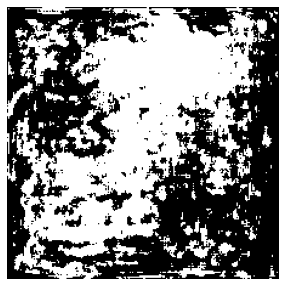

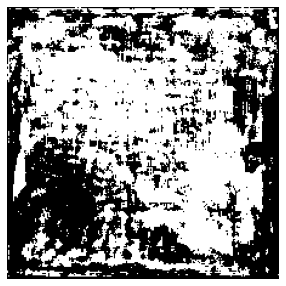

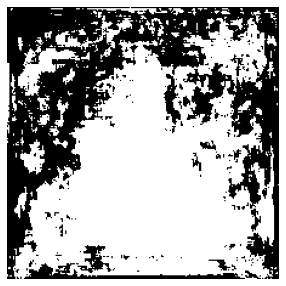

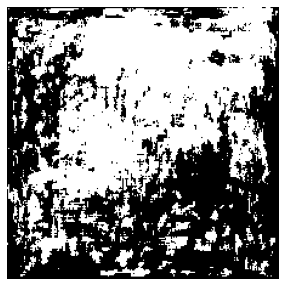














 33%|███▎      | 1/3 [00:00<00:01,  1.10it/s]

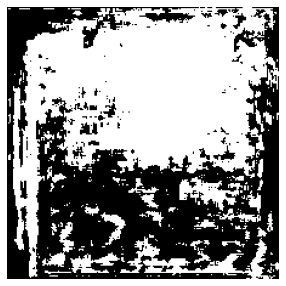

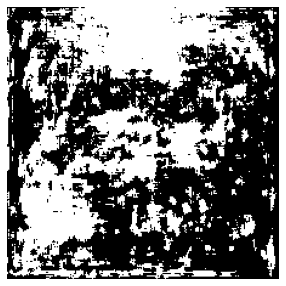

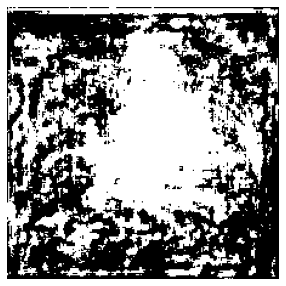

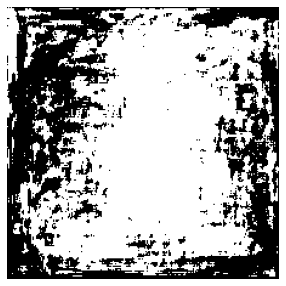














 67%|██████▋   | 2/3 [00:01<00:00,  1.26it/s]

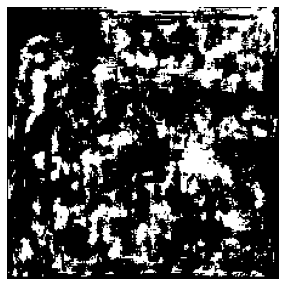

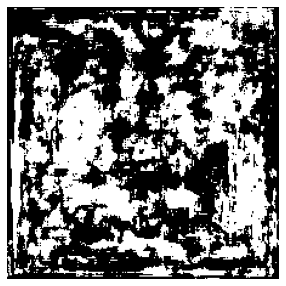














100%|██████████| 3/3 [00:02<00:00,  1.04it/s]


In [61]:
if(torch.cuda.device_count() > 1):
    model = nn.DataParallel(model)
model.to(device)

if(not args.save_results):
    train(args, loaders, model)
    model.load_state_dict(torch.load(args.model_dict_path))
    save_output(args, model, loaders['save'])
else:
    model.load_state_dict(torch.load(args.model_dict_path))
    save_output(args, model, loaders['save'])